In [1]:
import os
import json
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Ящики с усами

С помощью приложения мы собрали данные для того, чтобы нарисовать ящики с усами и разработать алгоритм, который бы позволил понять находится ли телефон в статичном положении (на столе) или в условно неподвижной руке.

Следует заметить, что "находиться в статичном положении" телефон может по разному: лежать на горизонтальной поверности или под каким-либом наклоном. Поэтому эксперименты проводились таким образом: делается запись показателей акселерометра в статичном положении под каким то углом, а потом в руке под схожим углом (конечно будут сильные отличия). Сравниваются показатели через графики с ящиками с усами.

Напишем код для графиков.

In [2]:
def get_results(file_name):
    file_path = os.path.join('data', file_name + '.json')
    with open(file_path, 'r') as f:
        results = json.loads(f.read())
    if len(results) == 0:
        print('{} is empty'.format(file_name))
        results = {'X' : 0, 'Y' : 0, 'Z' : 0}
    return results

def show_one_boxplot(axis, all_results, file_names):
    plt.boxplot([results[axis] for results in all_results], labels=file_names)
    plt.title('Сравнение {} {}'.format(axis, file_names), fontsize=15)
    plt.grid(True)

def show_boxplot(file_names):
    all_results = [get_results(file_name) for file_name in file_names]
    plt.figure(figsize=(20, 7))
    for i, axis in enumerate(['X', 'Y', 'Z']):
        plt.subplot(1, 3, i + 1)
        show_one_boxplot(axis, all_results, file_names)
    plt.show()

def show_boxplot_angle(angle):
    file_names = ['hand-{}'.format(angle), 'static-{}'.format(angle)]
    show_boxplot(file_names)

0 градусов - горизонтально экраном вверх

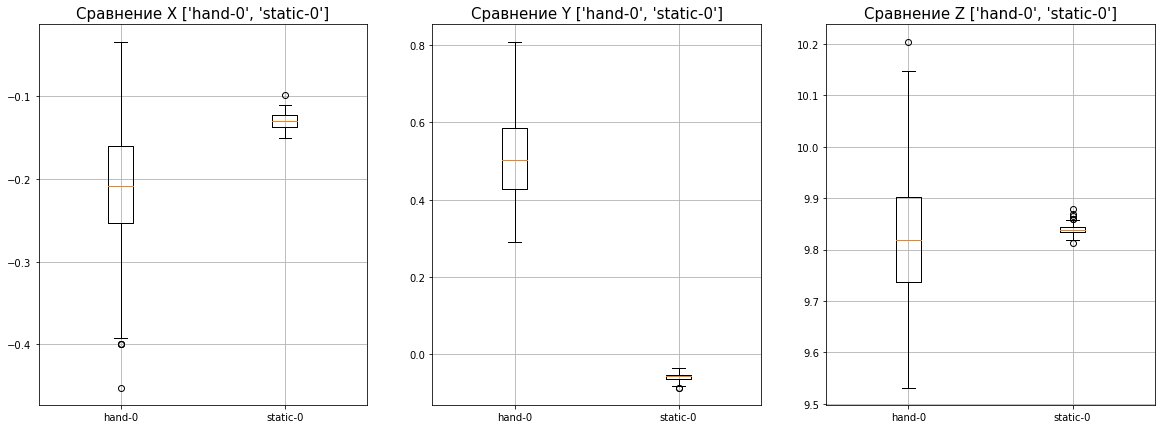

In [3]:
show_boxplot_angle(0)

45 градусов - "обычный" наклон телефона

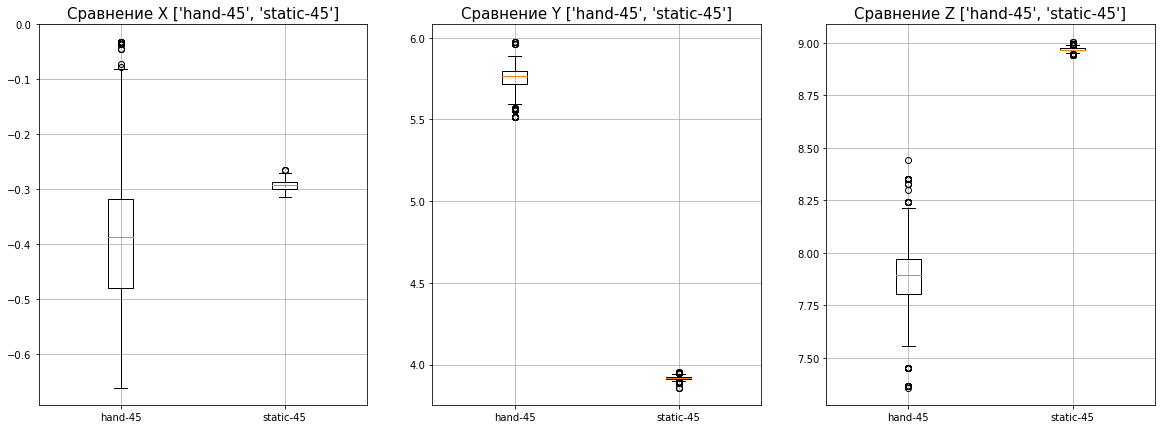

In [4]:
show_boxplot_angle(45)

90 градусов - поставили вертикально

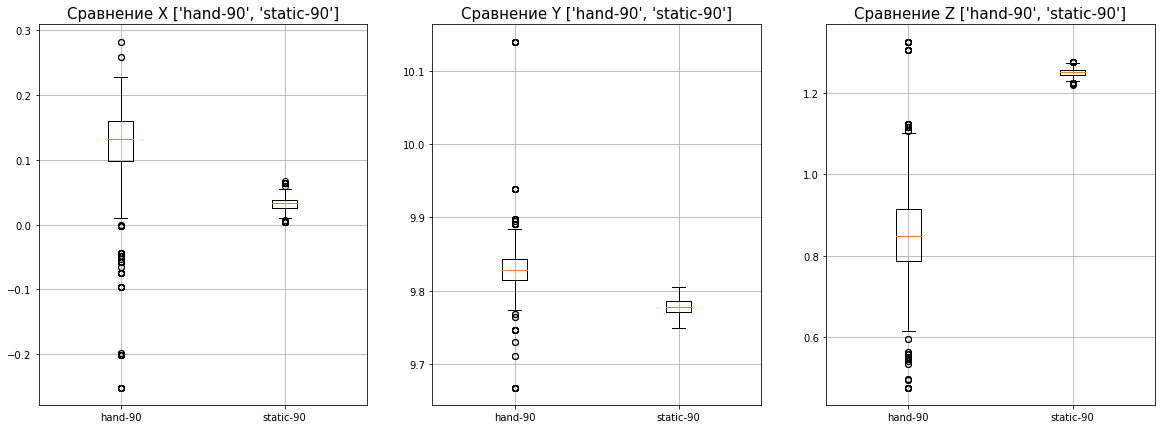

In [5]:
show_boxplot_angle(90)

135 градусов - наклон телефона вперед

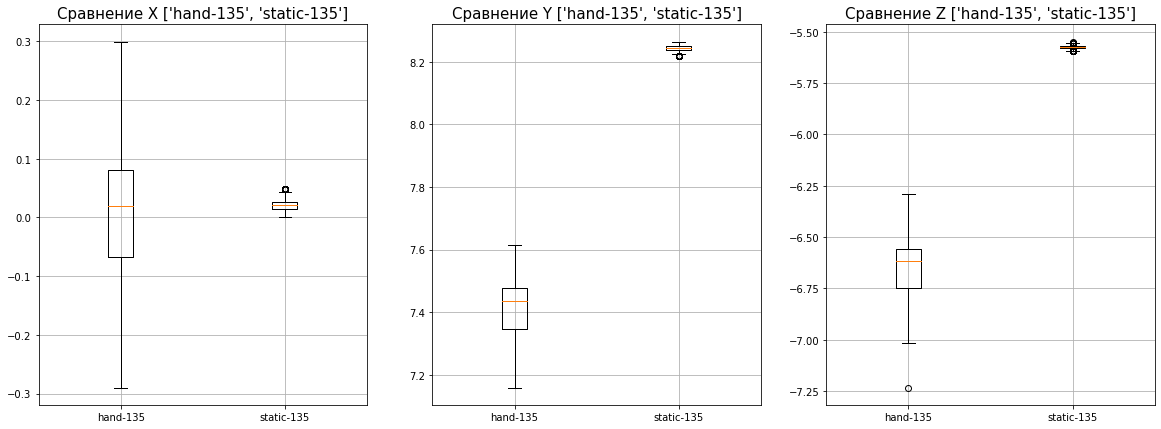

In [6]:
show_boxplot_angle(135)

180 градусов - горизонтально экраном вниз

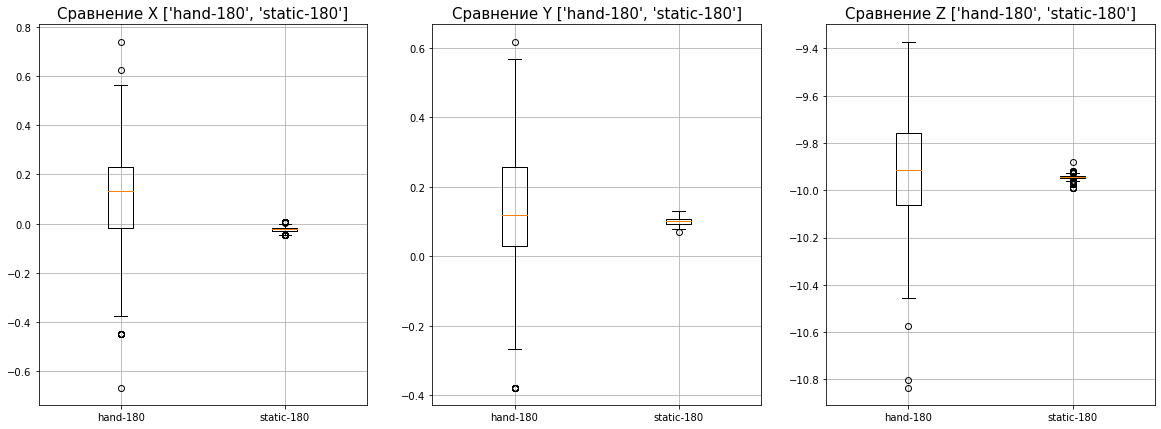

In [7]:
show_boxplot_angle(180)

Как и ожидалось: ящики с усами показателей акселерометра в статичном положении в отличии от положения "в руке" очень "сжаты" - медиана, нижний и верхний квартиль, минимальное и максимальное значение выборки максимально приближены друг к другу, выбросов почти нет. (а если есть, то скорее всего связаны с тем, что при нажатии на кнопку сохранения данных, телефон может немного дергаться)

## Алгоритм определения положения телефона

Таким образом можно взять нижний и верхний квартиль каждого показателя акселерометра и, если они все не отличаются по модулю на 0.05, то можно считать, что телефон находитчя в статичном положении, иначе - "в руке".

Напишем функцию определения.

In [8]:
def check_one_static(axis, results):
    Q1 = np.percentile(results[axis], 25)
    Q3 = np.percentile(results[axis], 75)
    return abs(Q1 - Q3) <= 0.05

def check_static(results):
    if len(results) == 0:
        return True
    answer = True
    for axis in ['X', 'Y', 'Z']:
        answer = answer and check_one_static(axis, results)
    return answer

Проверим работу на всех сохраненных файлах

In [12]:
def get_name(file_name):
    return ''.join(file_name.split('.')[:-1])

def check_all_files(dir_path):
    for file_name in os.listdir(dir_path):
        file_name = get_name(file_name)
        results = get_results(file_name)
        position = 'static' if check_static(results) else 'hand'
        print('File {} is in {}'.format(file_name, position))

In [13]:
check_all_files('data')

File hand-0 is in hand
File hand-135 is in hand
File hand-180 is in hand
File hand-45 is in hand
File hand-90 is in hand
File static-0 is in static
File static-135 is in static
File static-180 is in static
File static-45 is in static
File static-90 is in static


Обновим приложение с данным алгоритмом, чтобы оно показывало наиболее вероятное положение телефона на основе данных с предыдущего рестарта сбора показателей акселерометра.